In [596]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

In [597]:
train = pd.read_csv('train.csv', parse_dates=['date_of_registration'])

train['age'] = (pd.Timestamp('2024-10-13') - train['date_of_registration']) / pd.Timedelta(days=365)

In [598]:
# устранение пропусков
# в столбце complaints_count встречается '-', применяю to_numeric, чтобы превратить все не числовые значения в NaN
train['complaints_count'] = train['complaints_count'].apply(pd.to_numeric, errors='coerce')
# в столбце average_dwelltime встречается -1, сравниваю с 0, чтобы превратить все отрицательные значения в NaN 
train['average_dwelltime'] = train['average_dwelltime'].apply(lambda x: np.nan if x < 0 else x)
# в столбцах clicks, likes были пропуски и NaN изначально
# в complaints_count, average_dwelltime NaN поставили предыдущими шагами
# заменяю все найденные NaN на медиану
train[['clicks', 'likes', 'complaints_count', 'average_dwelltime']] = train[['clicks', 'likes', 'complaints_count', 'average_dwelltime']].apply(lambda col: col.fillna(col.median()), axis=0)

In [599]:
categorial_features = ['category'] # категориальный
real_features = ['clicks', 'likes', 'buys', '4xx_errors', '5xx_errors', 'complaints_count', 'average_dwelltime', 'age'] # вещественные
target_features = 'source_attractiveness' # целевой

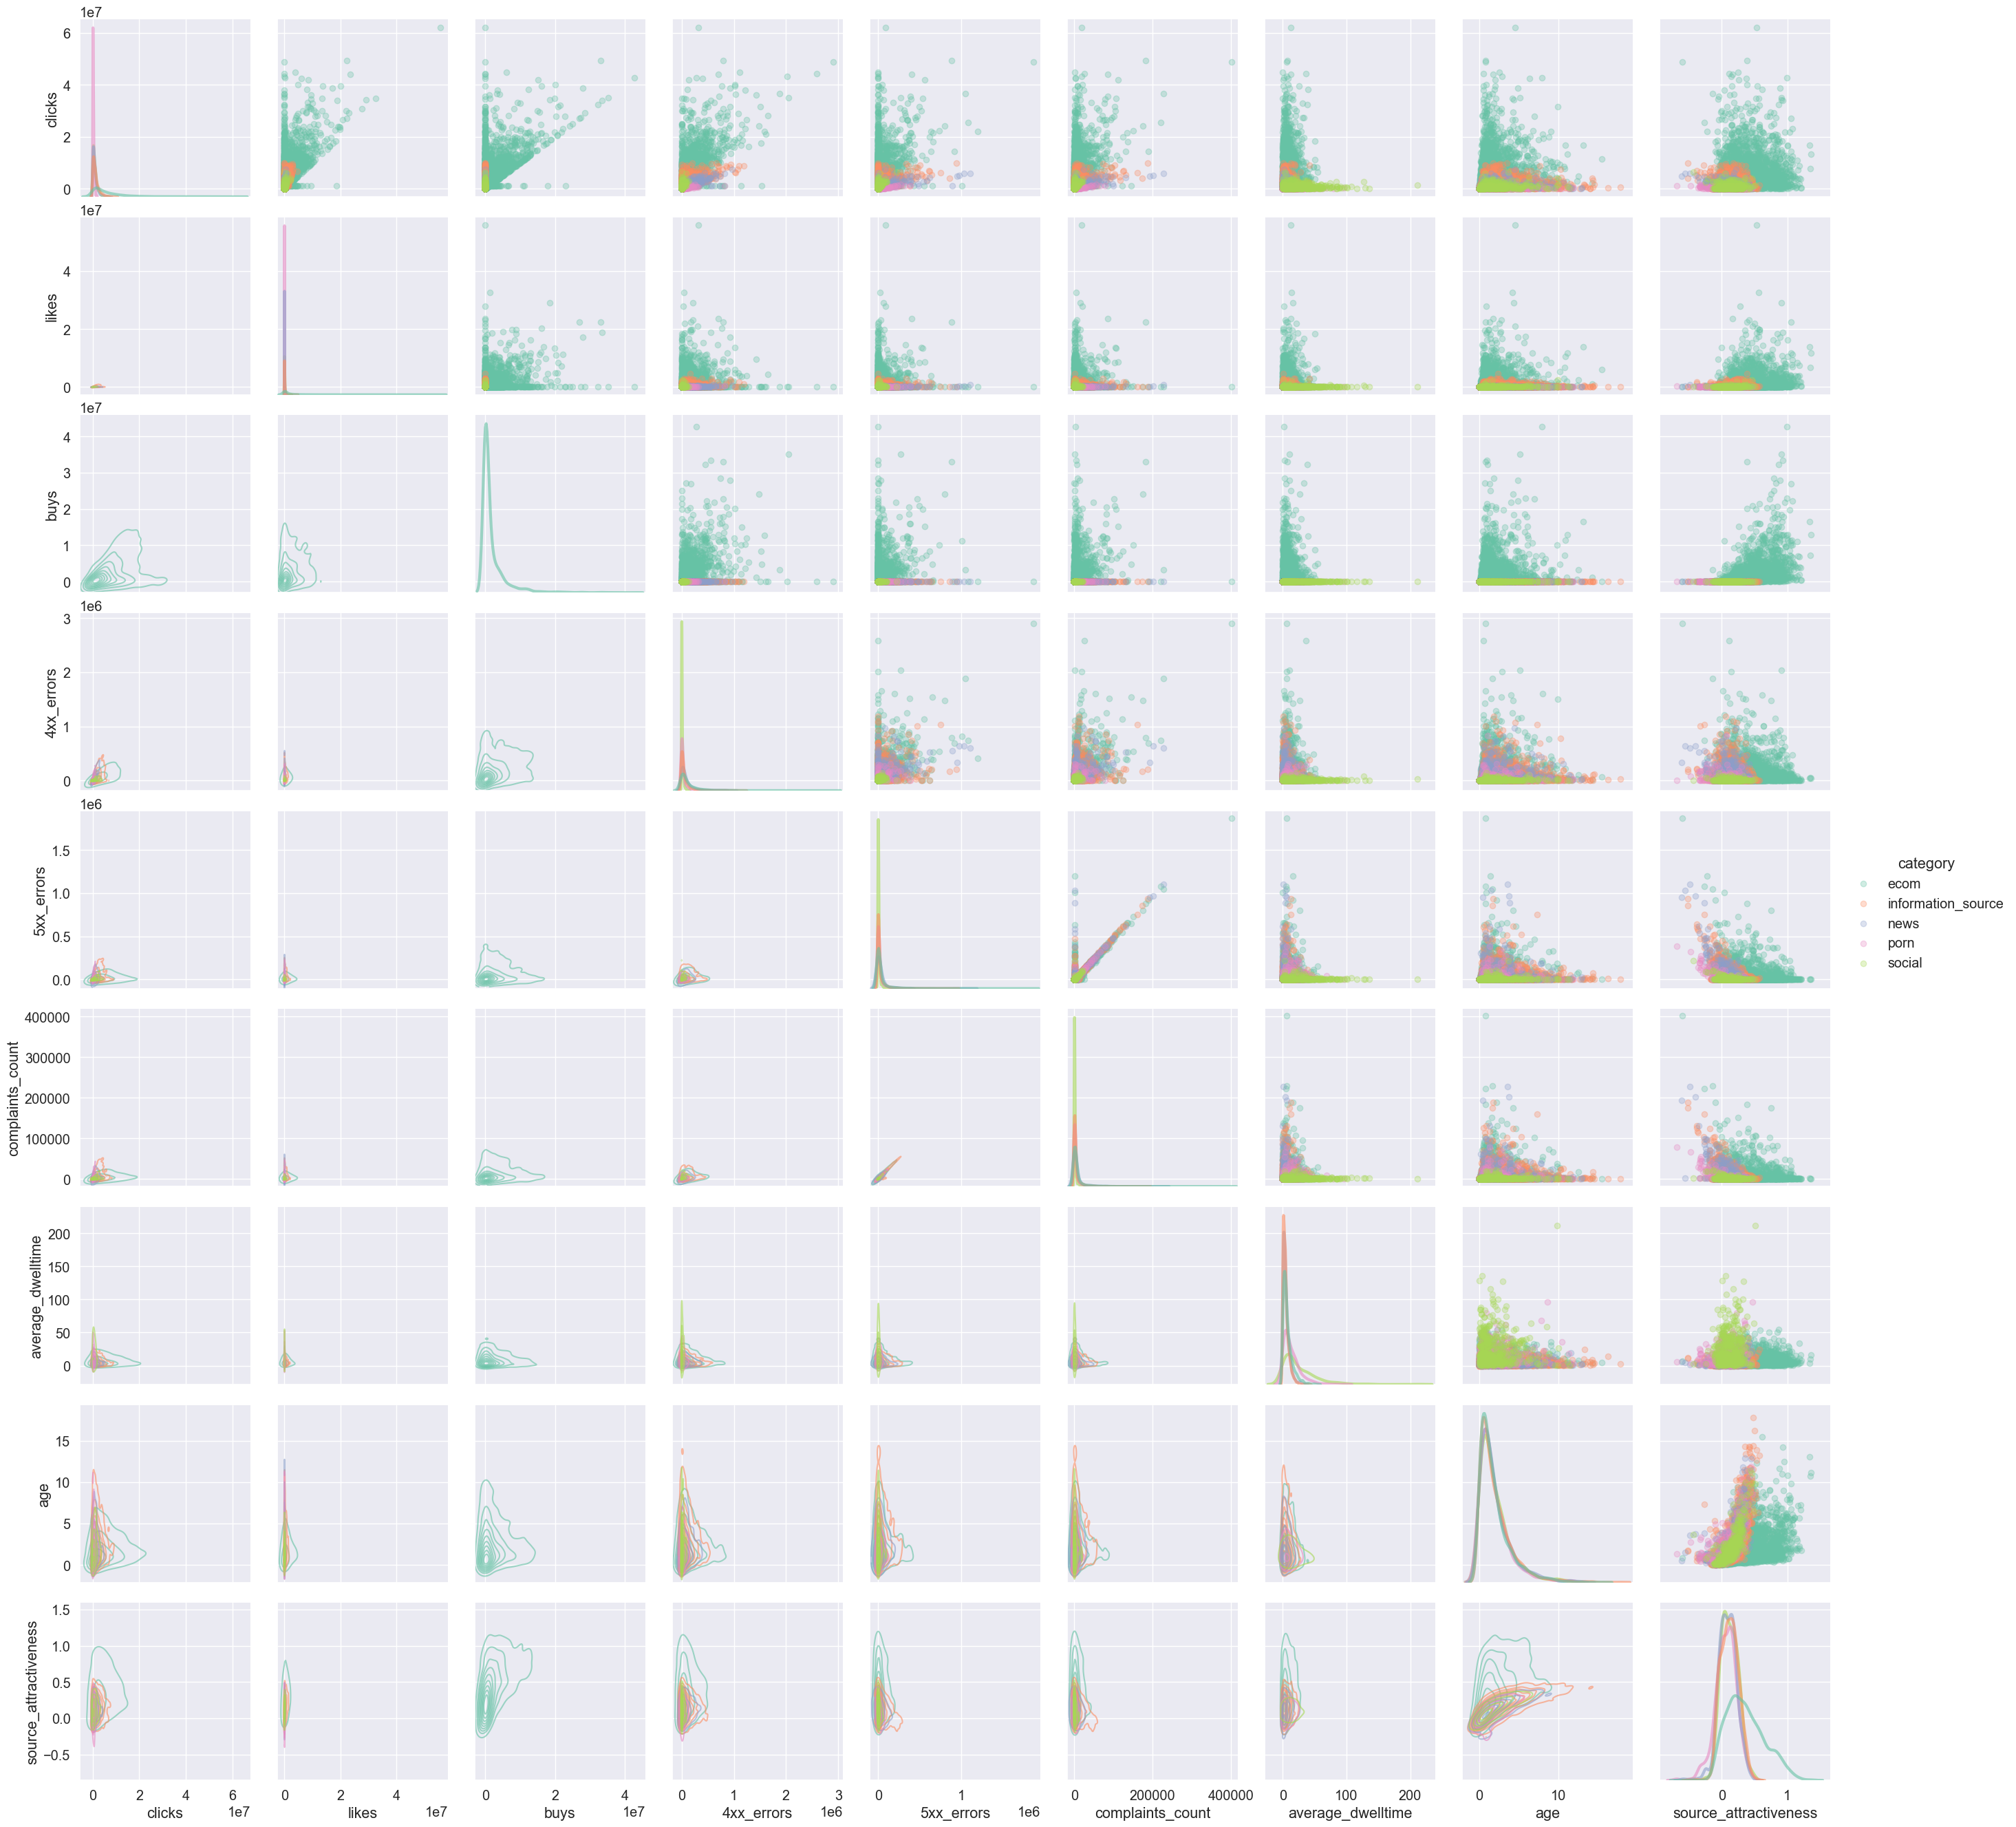

In [604]:
import warnings
warnings.filterwarnings('ignore')
for hue in categorial_features:
    g = sns.PairGrid(train[[*(real_features + [target_features]), hue]], hue=hue, diag_sharey=False, height=3)
    g.map_lower(sns.kdeplot, alpha=0.6)
    g.map_upper(plt.scatter, alpha=0.3)
    g.map_diag(sns.kdeplot, lw=3, alpha=0.6, common_norm=False)
    g.add_legend()

Из графиков можно сделать выводы:
- Самые лучшие оценки привлекательности получают только интернет-магазины
- Чем меньше ошибок и жалоб, тем лучше оценка, при чем ошибки 5xx влияют сильнее
- Количество ошибок 5xx напрямую влияет на количество жалоб и соответственно на оценку
- Пользователи стремятся покупать на онлайн-магазинах с лучшой оценкой
- Большинство покупок производится через интернет-магазины
- Часть пользователей проводят больше всего времени в соц сетях, делая при этом малое число кликов и покупок
- Чем 'моложе' сайт тем меньше среденее время проведенное пользователем

In [601]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
train_cat = encoder.fit_transform(train[categorial_features])

X_train = np.hstack([train[real_features], train_cat])

In [602]:
model = LinearRegression(fit_intercept=True)
model.fit(X_train, train[target_features])

LinearRegression()

In [603]:
def predict(data_path):
    test = pd.read_csv(data_path, parse_dates=['date_of_registration'])
    
    test['age'] = (pd.Timestamp('2024-10-13') - test['date_of_registration']) / pd.Timedelta(days=365)
    test['complaints_count'] = test['complaints_count'].apply(pd.to_numeric, errors='coerce')
    test['average_dwelltime'] = test['average_dwelltime'].apply(lambda x: np.nan if x < 0 else x)
    test[['clicks', 'likes', 'complaints_count', 'average_dwelltime']] = test[['clicks', 'likes', 'complaints_count', 'average_dwelltime']].apply(lambda col: col.fillna(col.median()), axis=0)
    
    test_cat = encoder.transform(test[categorial_features])
    X_test = np.hstack([test[real_features], test_cat])
    
    predicts = model.predict(X_test)
    data = {
        "source_attractiveness": predicts
    }
    submit = pd.DataFrame(data)
    submit.to_csv('submission.csv', index_label="ID")

In [595]:
predict('test.csv')